In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Utilities.basic_units import radians
from src import orbits as orb
from Utilities import sections as sec

from Utilities.operators import make_tree, Ryan_sampler, to_cylindric
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

<Figure size 800x600 with 0 Axes>

In [9]:
abspath = '/Users/paolamartire/shocks/'
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
params = [Mbh, Rstar, mstar, beta]
check = 'Low' # '' or 'HiRes' or 'Res20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '164'
path = f'{abspath}TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = Rt**2 / Rstar #2 * Rt * (Mbh/mstar)**(1/3)

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))
c = 3e8 / (7e8/t)

Rs = 2*G*Mbh / c**2

# cfr tidal disruption and at smoothing lenght
xcfr, ycfr, cfr = orb.make_cfr(Rt)
xcfr0, ycfr0, cfr0 = orb.make_cfr(R0)

We are in: /Users/paolamartire/shocks/TDE/R0.47M0.5BH10000beta1S60n1.5Low/164, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/Low


Load data

In [3]:
data = make_tree(path, snap, energy = False)

# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(data.X**2 + data.Y**2 + data.Z**2)
THETA, RADIUS_cyl = to_cylindric(data.X, data.Y)
V = np.sqrt(data.VX**2 + data.VY**2 + data.VZ**2)
Vcyl = np.sqrt(data.VX**2 + data.VY**2)
orb_en = orb.orbital_energy(RADIUS_cyl, Vcyl, G, Mbh)
dim_cell = data.Vol**(1/3) 

tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]

days after disruption: 1.3532153925058021 // t_fall: 2.5777261297507925 // sim_time: 73.40236449912129


Midplane 

In [4]:
stream = np.load(f'/Users/paolamartire/shocks/data/{folder}/stream_{check}{snap}.npy')
theta_arr, x_stream, y_stream, z_stream = stream[0], stream[1], stream[2], stream[3]
stream = [x_stream, y_stream, z_stream]

In [5]:
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, Temp_midplane, = \
    sec.make_slices([data.X, data.Y, data.Z, dim_cell, data.Mass, data.Den, data.Temp], midplane)

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.525')

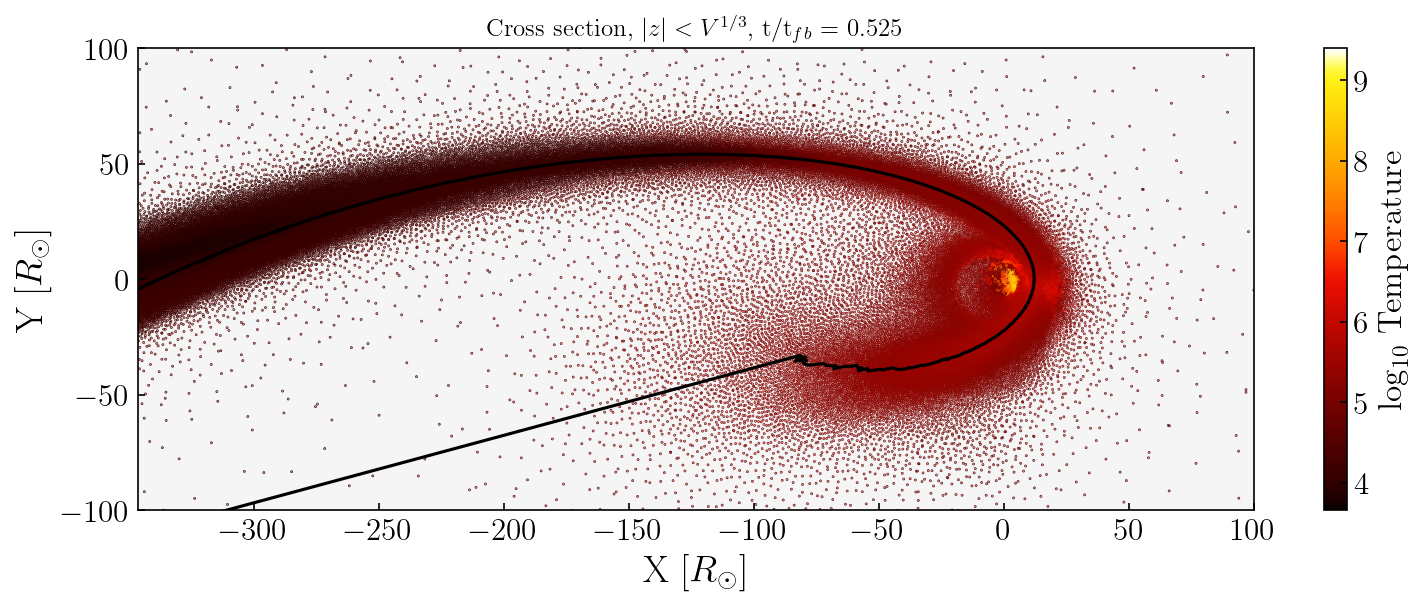

In [6]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane, Y_midplane, c = np.log10(Temp_midplane), s = .1, cmap = 'cet_fire')#, vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax.plot(x_stream, y_stream, c = 'k')
ax.set_xlim(-50,100)
ax.set_ylim(20,40)
ax.set_xlim(-apo,100)
ax.set_ylim(-100,100)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))



Tangent and transverse plane

In [7]:
idx = 98
condition_tra, x_onplane, x0 = sec.transverse_plane(data.X, data.Y, data.Z, dim_cell, x_stream, y_stream, z_stream, idx, coord= True)
X_tra, Y_tra, Z_tra, Den_tra, Mass_tra, dim_tra = \
    sec.make_slices([data.X, data.Y, data.Z, data.Den, data.Mass, dim_cell], condition_tra)
X_tra_midplane = X_tra[np.abs(Z_tra) < dim_tra]
Y_tra_midplane = Y_tra[np.abs(Z_tra) < dim_tra]

In [10]:
indeces_boundary, x_T_width, w_params, h_params, thresh = orb.find_single_boundaries(data.X, data.Y, data.Z, dim_cell, data.Mass, stream , idx, params)


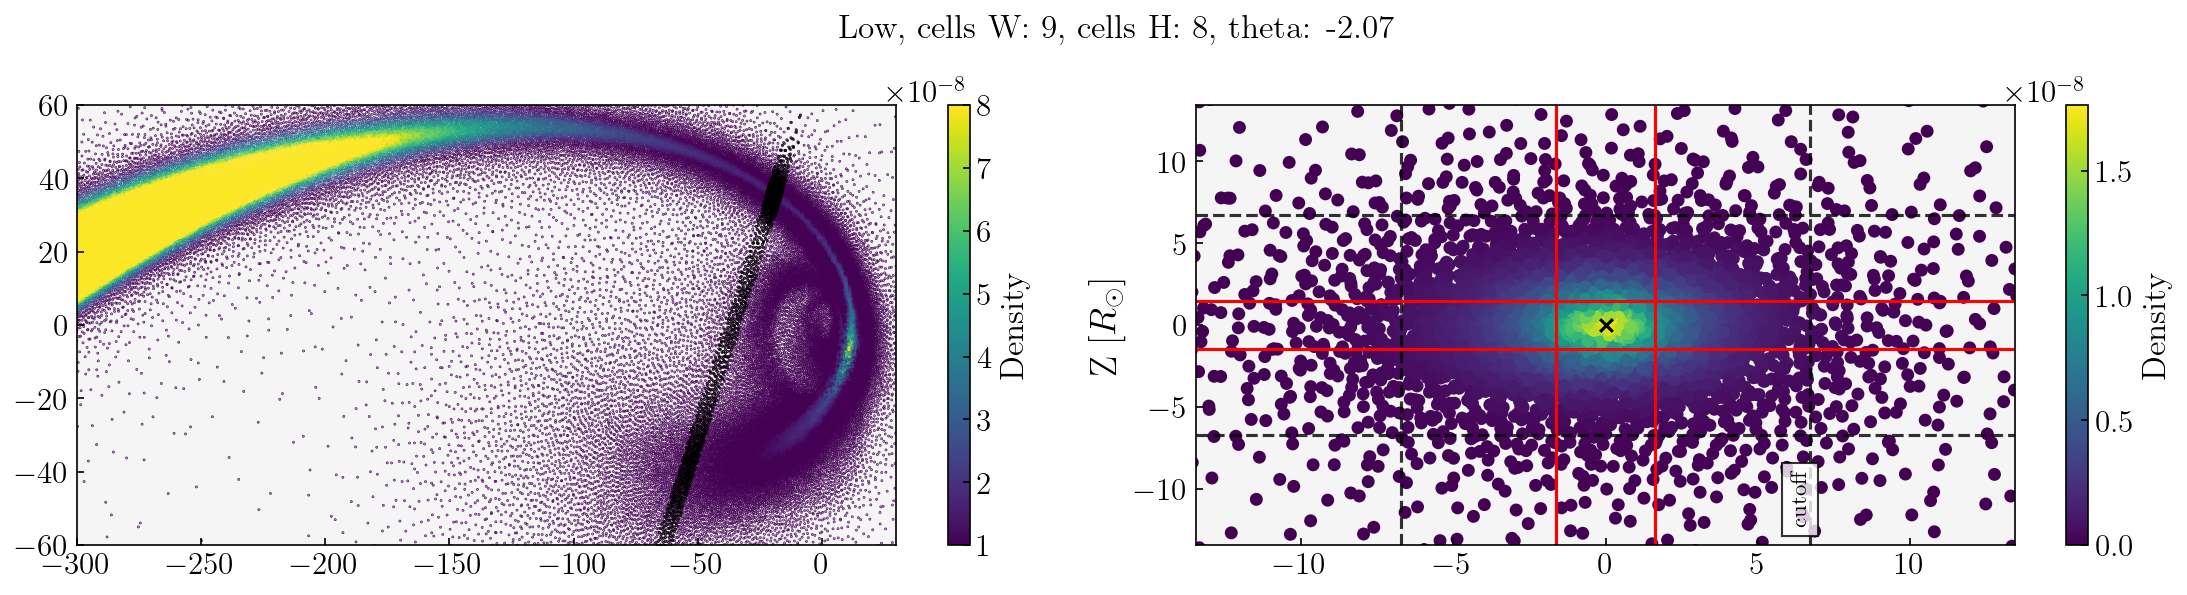

In [14]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
img = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = 1e-8, vmax = 8e-8)
cbar = plt.colorbar(img)
cbar.set_label(r' Density', fontsize = 16)
ax[0].scatter(X_tra_midplane, Y_tra_midplane, s = 0.1, c = 'k')
ax[0].set_xlim(-300,30)
ax[0].set_ylim(-60,60)

img1 = ax[1].scatter(x_onplane, Z_tra, c = Den_tra,  cmap = 'viridis', s = 27)
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Density', fontsize = 16)
ax[1].scatter(0, z_stream[idx], marker = 'x', s = 37, c = 'k', alpha = 1)
ax[1].axvline(x_T_width[0], c = 'r')
ax[1].axvline(x_T_width[1], c = 'r') # T coordinates for width
ax[1].axvline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].axvline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].text(0.9*thresh, -1.8*thresh, 'cutoff',fontsize = 11, rotation = 90,  bbox=dict(facecolor='white', alpha=0.8))
ax[1].set_xlim(-2*thresh, 2*thresh)

ax[1].axhline(data.Z[indeces_boundary[2]], c = 'r')
ax[1].axhline(data.Z[indeces_boundary[3]], c = 'r')
ax[1].axhline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].axhline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
ax[1].set_ylim(-2*thresh, 2*thresh)

ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18) 
plt.suptitle(f'{check}, cells W: {int(w_params[1])}, cells H: {int(h_params[1])}, theta: {np.round(theta_arr[idx], 2)}', fontsize = 16)
plt.tight_layout()
